# Tag in an empty world

In [1]:
import sys

sys.path.append("../..")

from grid_world.action import GWorldAction
from grid_world.visualization.format_objects import get_world_str
from utils.returns import returns_from_reward
from notebooks.utils.basics import basic_actions, basic_tag_reward
from exploring_agents import QAgent, RandomAgent, SarsaAgent, LambdaSarsaAgent
from notebooks.utils.experimentation import moving_average
from exploring_agents.training import train_tag_agents
from notebooks.utils.worlds import tagging_world_00
from grid_world.action import GWorldAction
from exploring_agents.commons.dacaying_functions import get_exp_decay


import matplotlib.pyplot as plt
import numpy as np

np.random.seed(50)

In [2]:
gworld = tagging_world_00
print(get_world_str(gworld))

5                ⚐ 

4                  

3                  

2                  

1                  

0 ⚐                

  0  1  2  3  4  5 


## Basic behaviour

In [3]:
basic_agent_1 = QAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.1,
    epsilon=0.01,
)

basic_agent_2 = QAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=1,
    alpha=0.1,
    epsilon=0.01,
)

basic_episode_lengths, basic_agent_1_returns, basic_agent_2_returns = train_tag_agents(
    agent_1=basic_agent_1,
    agent_2=basic_agent_2,
    world=gworld,
    episodes=int(1e4),
    episode_max_length=200,
)

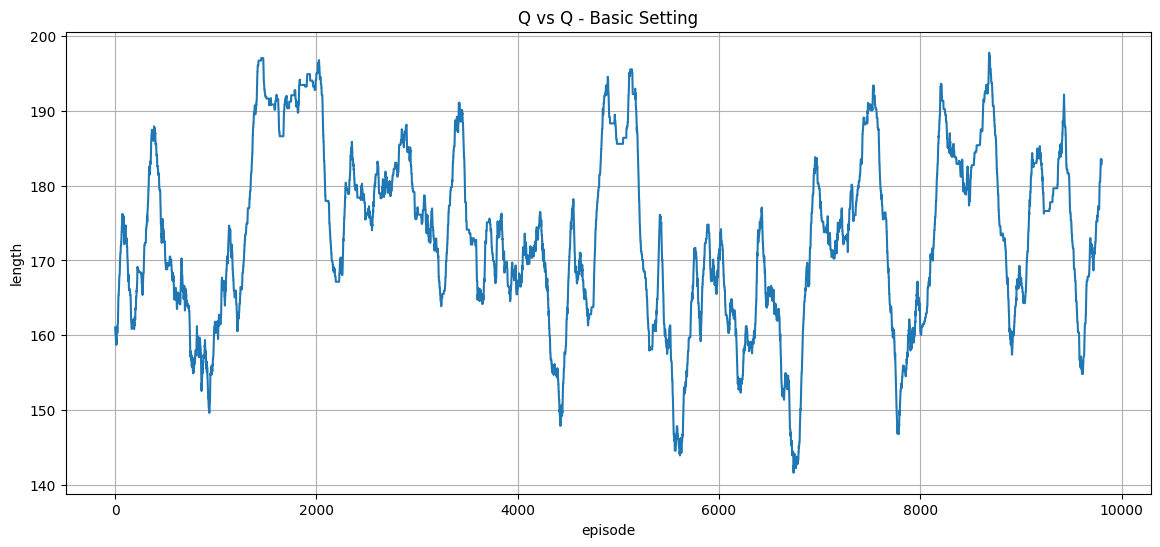

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(basic_episode_lengths), 200),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Q vs Q - Basic Setting")


plt.show()

This problem is hopeless for Agent 1, all Agent 2 needs to do is make sure that there is at least one saquare separation between then; and since he can "pass" his moves by running into the wall he never gets cornered. In fact Agent 1 only ocasionally wins because of the exploratory moves of Agent 2. Lets see what happens when we remove then, and let the agents continue to interact.

In [5]:
basic_agent_2.policy.epsilon = 0


(
    basic_episode_lengths_2,
    basic_agent_1_returns_2,
    basic_agent_2_returns_2,
) = train_tag_agents(
    agent_1=basic_agent_1,
    agent_2=basic_agent_2,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
)

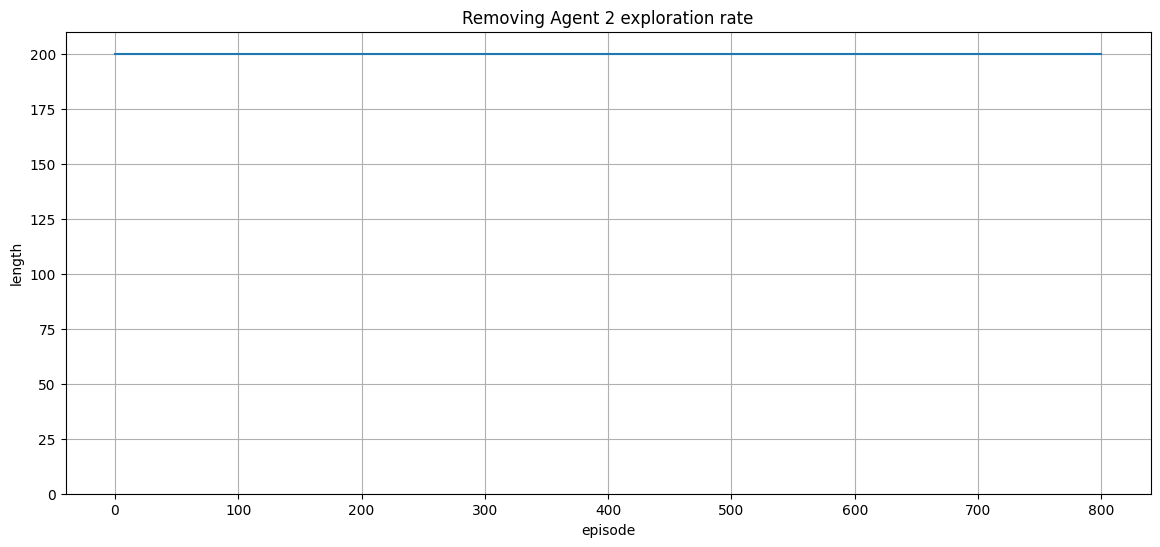

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(moving_average(np.array(basic_episode_lengths_2), 200))

ax.set(xlabel="episode", ylabel="length", ylim=(0, 210))
ax.grid()
ax.set_title("Removing Agent 2 exploration rate")


plt.show()

As expected, Agent 1 has no chance.

## Diagonal Movements

In [7]:
agent_1 = QAgent(
    reward_function=basic_tag_reward,
    actions=[x for x in GWorldAction],
    gamma=0.9,
    alpha=0.1,
    epsilon=0.01,
)

agent_2 = QAgent(
    reward_function=basic_tag_reward,
    actions=[x for x in GWorldAction],
    gamma=1,
    alpha=0.1,
    epsilon=0.01,
)

episode_lengths, agent_1_returns, agent_2_returns = train_tag_agents(
    agent_1=agent_1,
    agent_2=agent_2,
    world=gworld,
    episodes=int(2 * 1e4),
    episode_max_length=200,
    # randomize_starting_positions=True
)

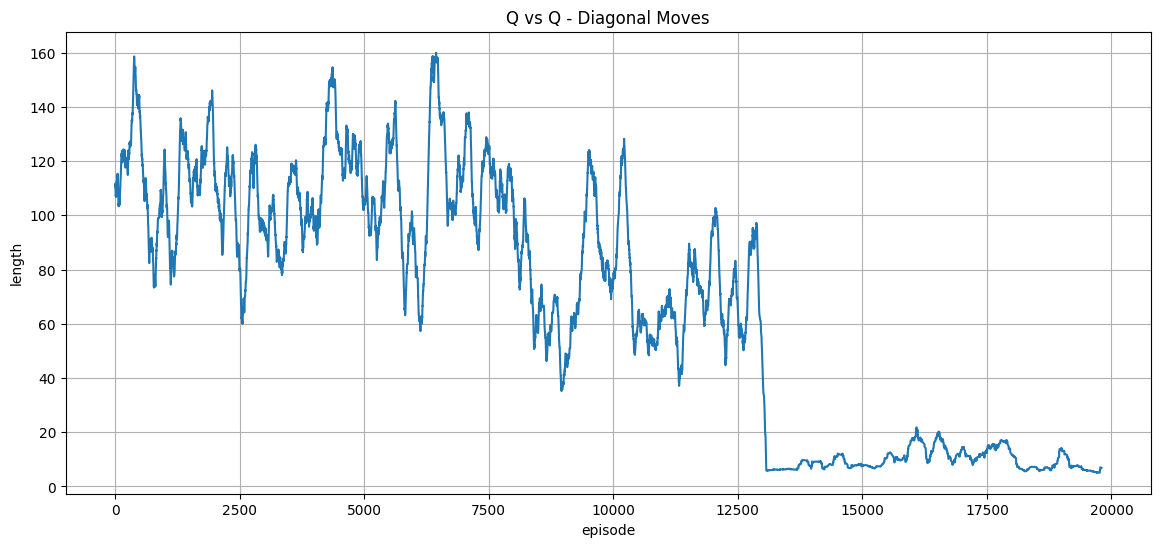

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(episode_lengths), 200),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Q vs Q - Diagonal Moves")


plt.show()

Giving both access to diagonal moves make it so Agent 1 is able to corner Agent 2, and catch him. Swinging the problem in his favor.

## Agent 2 with high exploration

Going back to the basic moves, there is one interesting detail we can look at. Both agents have an exploration policy, which ensure they make a "bad" move every now and then. This is the only reason why Agent 1 can win some rounds. So lets see if Agent 1 learns to explore these bad moves, by giving Agent 2 a high exploration rate.

For this experiment we will also set the agents to start at random positions. This is suggested at some point by Suton and Bartoo, as a way to ensure agents experience lots of different states, and I think it is particularly usefull for this problem; but it does require training for a long time.

In [9]:
he_agent_1 = QAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.1,
    epsilon=0.01,
)

he_agent_2 = QAgent(
    reward_function=basic_tag_reward,
    actions=basic_actions,
    gamma=0.9,
    alpha=0.1,
    epsilon=0.1,
)

he_episode_lengths, he_agent_1_returns, he_agent_2_returns = train_tag_agents(
    agent_1=he_agent_1,
    agent_2=he_agent_2,
    world=gworld,
    episodes=int(1e5),
    episode_max_length=200,
    randomize_starting_positions=True,
)

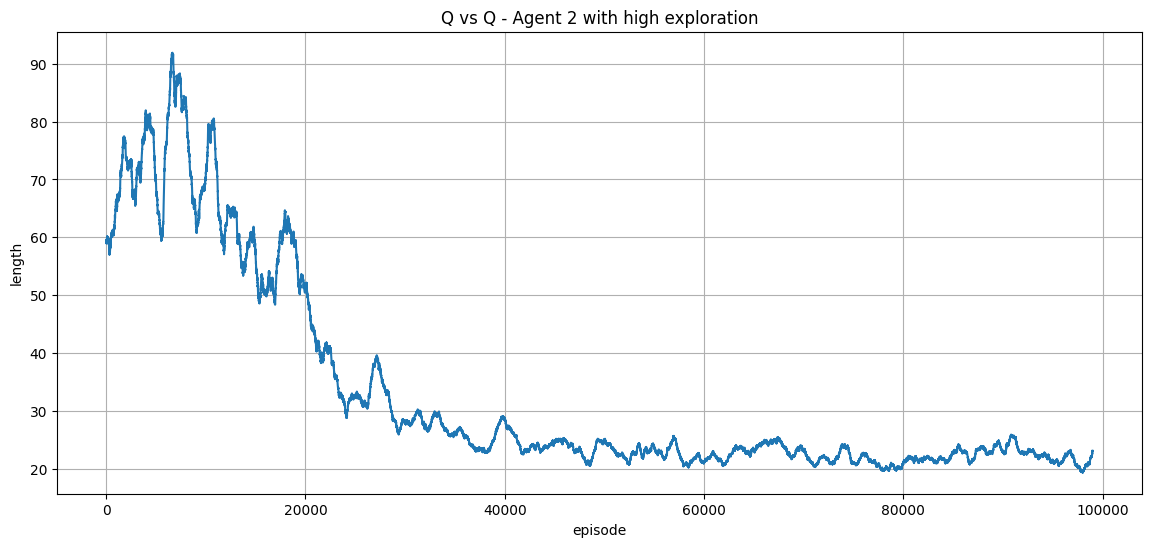

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(he_episode_lengths), 1000),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Q vs Q - Agent 2 with high exploration")


plt.show()

Nice! We see that Agent 1 really seems to learn how to explore these bad moves. Lets train the agents a little more, from the start position. 

In [11]:
he_episode_lengths, he_agent_1_returns, he_agent_2_returns = train_tag_agents(
    agent_1=he_agent_1,
    agent_2=he_agent_2,
    world=gworld,
    episodes=int(1e4),
    episode_max_length=200,
    randomize_starting_positions=False,
)

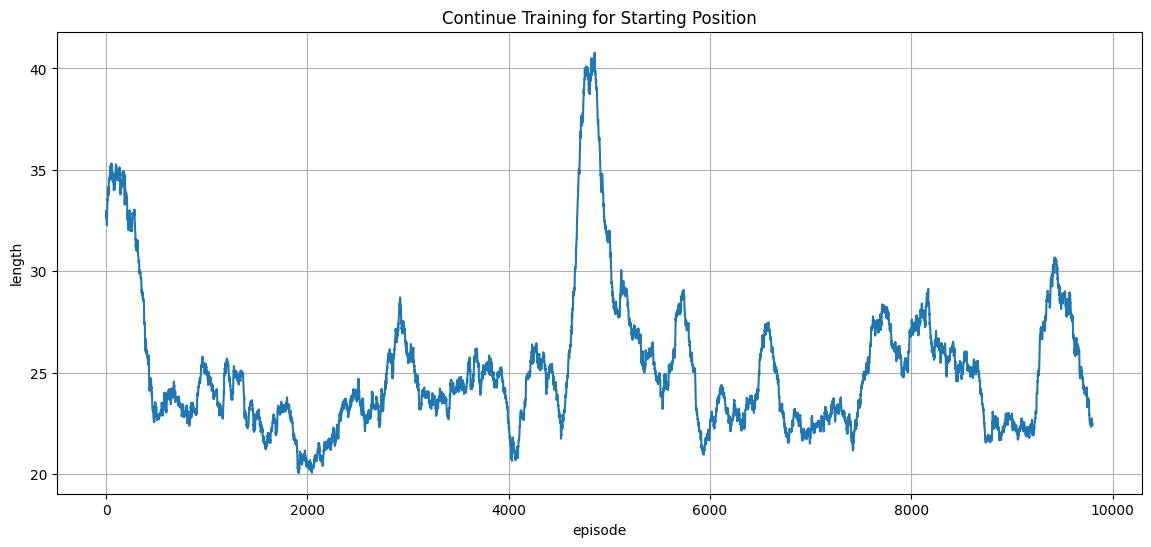

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    moving_average(np.array(he_episode_lengths), 200),
)

ax.set(xlabel="episode", ylabel="length")
ax.grid()
ax.set_title("Continue Training for Starting Position")


plt.show()

Nothing surprising here, Agent 1 keeps winning relatively fast. I'll dump these agent so we can check their strategy by running:

``` python grid_world/visualization/animation_scripts/tag/q_vs_q_00.py ```

If you run this you will notice that we finally have agents behaving in a more reasonable way. Agent 1 will try to chase Agent 2 who will run from it untill it makes a bad(exploratory) move and loses.

In [13]:
base_path = "../.."
prefix = f"{base_path}/persistence/agents/"
filename1 = "q_agent_1_tagging_world_00"
filename2 = "q_agent_2_tagging_world_00"

he_agent_1.dump(f"{prefix}{filename1}")
he_agent_2.dump(f"{prefix}{filename2}")

Notice that there is nothing wrong with Agent 2 $Q$ estimates, he just loses because of the policy. And if we seet its exploration rate to 0 he will start winning.

In [14]:
he_agent_2.policy.epsilon = 0

he_episode_lengths_2, he_agent_1_returns_2, he_agent_2_returns_2 = train_tag_agents(
    agent_1=he_agent_1,
    agent_2=he_agent_2,
    world=gworld,
    episodes=int(1e3),
    episode_max_length=200,
    randomize_starting_positions=False,
)

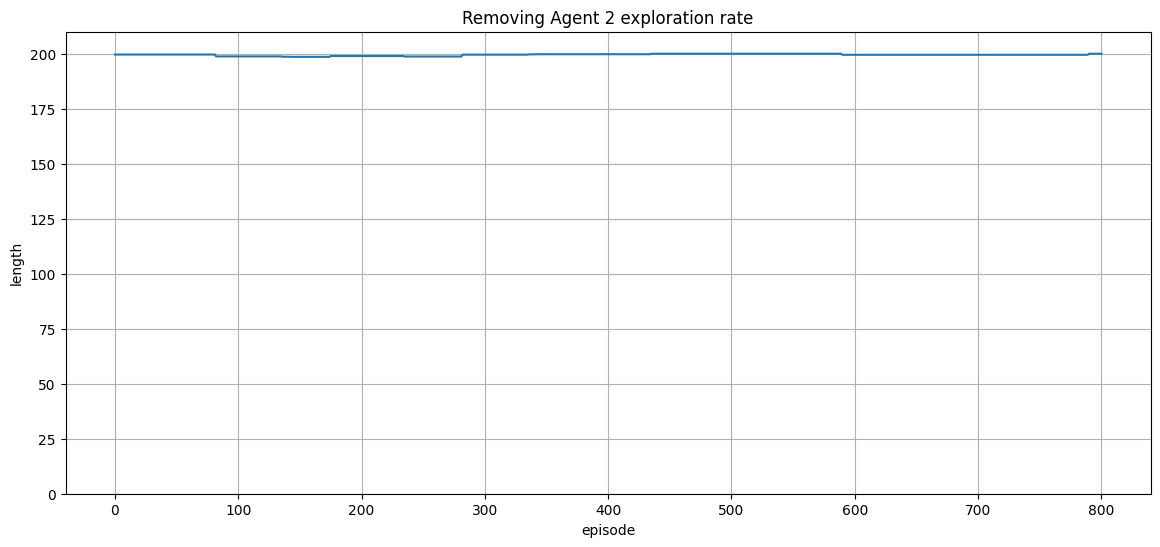

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(moving_average(np.array(he_episode_lengths_2), 200))

ax.set(xlabel="episode", ylabel="length", ylim=(0, 210))
ax.grid()
ax.set_title("Removing Agent 2 exploration rate")


plt.show()